In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import re
import lightgbm as lgb

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
song = pd.read_csv('songs.csv')
members =  pd.read_csv('members.csv')

In [3]:
msk = np.random.rand(len(train)) <= 0.75
train_df = train[msk]
val_df = train[~msk]

In [4]:
train = train_df
test = val_df

In [5]:
#user_bias, user_freq, song_bias, song_freq
tuf = train.groupby('msno')['target'].agg(['sum','count']) 
tuf = tuf.reset_index()
tuf.columns.values[1:3] = ['user_sum','user_count']
tuf['user_freq'] = (tuf.user_sum+1)/(tuf.user_count+2) #Laplacian smoothing
train = train.merge(tuf,on = 'msno',how = 'left')
train.loc[train.user_count == 1,'user_sum'] = 0 
train.loc[train.user_count == 1,'user_freq'] = 0.5 
train['is_new_user'] = train.user_count == 1

#prepare test's user bias
test = test.merge(tuf,on = 'msno',how = 'left')
test['is_new_user'] = pd.isnull(test.user_count)
test.loc[pd.isnull(test.user_count),'user_count'] = 1
test.loc[pd.isnull(test.user_sum),'user_sum'] = 0
test.loc[pd.isnull(test.user_freq),'user_freq'] = 0.5

#prepare songs' bias
tuf = train.groupby('song_id')['target'].agg(['sum','count']) #Laplacian smoothing
tuf = tuf.reset_index()
tuf.columns.values[1:3] = ['song_sum','song_count']
tuf['song_freq'] = (tuf.song_sum+1)/(tuf.song_count+2)
train = train.merge(tuf,on = 'song_id',how = 'left')
train.loc[train.song_count == 1,'song_sum'] = 0
train.loc[train.song_count == 1,'song_freq'] = 0.5 
train['is_new_song'] = train.song_count == 1

#prepare test's songs' bias
test = test.merge(tuf,on = 'song_id',how = 'left')
test['is_new_song'] = pd.isnull(test.song_count)
test.loc[pd.isnull(test.song_count),'song_count'] = 1
test.loc[pd.isnull(test.song_freq),'song_freq'] = 0.5
test.loc[pd.isnull(test.song_sum),'song_sum'] = 0

Artist Preparation: 
1. find the intersection of artist between the train and test
2. treat the compound artist seperately from single artist
3. if a single artist from test set hasn't appeared before, we can do nothing, however, if a compound artist has appeared, we can possibly estimate it from the single artist's contribution
4. add a dummy variable artist_estimated to show

In [6]:
def split(x):
    l = re.split("[+|&/]",x)
    l = [i.strip() for i in list(l)]
    return l

In [7]:
train = train.merge(song,on= 'song_id',how = 'left')
test = test.merge(song,on = 'song_id',how = 'left')

In [8]:
train.artist_name = train.artist_name.fillna("no_rec")
test.artist_name = test.artist_name.fillna("no_rec")

In [9]:
train_art = set()
for name in train.artist_name.unique():
    train_art.add(name)
    for sub in split(name):
        train_art.add(sub.strip())

In [10]:
test_art_diff = set()
for name in test.artist_name.unique():
    indic = [sub.strip() in train_art for sub in split(name)]
    if not any(indic):
        test_art_diff.add(name)
#19%的artist从来没有出现过

In [11]:
tt_csame = set()
for name in test.artist_name.unique():
     if len(split(name)) > 1 and name in train_art:
            tt_csame.add(name)

In [12]:
tt_single = set()
for name in train.artist_name.unique():
    if len(split(name)) == 1:
        tt_single.add(name)

In [13]:
tt_cdump = set()
for name in train.artist_name.unique():
    if len(split(name)) > 1 and not name in tt_csame:
        tt_cdump.add(name)

In [14]:
artdict = dict(zip(list(train_art),range(len(train_art))))
userdict = dict(zip(train.msno.unique(),range(train.msno.nunique())))
v = train.groupby(['msno','artist_name'])['target'].agg(['sum','count'])
v = v.reset_index()
v.columns.values[2:] = ['uasum','uacount']
uamat = sparse.lil_matrix((len(userdict),2*len(artdict)))
v['mind'] = v.msno.apply(lambda x: userdict[x])
v['amind'] = v.artist_name.apply(lambda x: artdict[x])
for i in v.index:
    uamat[v.mind[i],2*v.amind[i]] = v.uasum[i]
    uamat[v.mind[i],2*v.amind[i]+1] = v.uacount[i]
disdict = {}
for key, ind in artdict.items():
    l = [artdict[sub] for sub in split(key) if not sub in tt_single]
    if len(l) > 0:
        disdict[key] = (l,ind)
uamat = sparse.csc_matrix(uamat)
for key, ind in disdict.items():
    for sub in ind[0]:
        uamat[:,2*sub] += uamat[:,2*ind[1]]
        uamat[:,2*sub+1] += uamat[:,2*ind[1]+1]

/Applications/Anaconda/anaconda/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [15]:
#prepare train artist feature
oart = train.groupby('artist_name')['target'].agg(['sum','count'])
oart = oart.reset_index()
oart.columns.values[1:3] = ['art_sum','art_count']
oart['art_freq'] = (oart.art_sum+1)/(oart.art_count+2)
train = train.merge(oart,on='artist_name',how = 'left')
train.loc[train.art_count == 1,'art_sum'] = 0
train.loc[train.art_count == 1,'art_freq'] = 0.5
train['is_new_art'] = train.art_count == 1
traindump = train[train.artist_name.isin(list(tt_cdump))]
train['is_art_dump'] = 0
uasum = uamat.sum(axis = 0)
for name,group in traindump.groupby("artist_name"):
    subind = np.array([artdict[sub.strip()] for sub in split(name)])
    gasum = uasum[0,2*subind].sum()/len(subind)
    gacount = uasum[0,2*subind+1].sum()/len(subind)
    for ind in group.index:
        train.set_value(ind,'art_sum',gasum)
        train.set_value(ind,'art_count',gacount)
        train.set_value(ind,'art_freq',(gasum+1)/(gacount+2))
        train.set_value(ind,'is_art_dump',1)

In [16]:
#prepare test artist feature
test = test.merge(oart,on='artist_name',how = 'left')
test['is_art_dump'] = 0
test['is_new_art'] = 0
testnan = test[pd.isnull(test.art_sum)]
test.loc[pd.isnull(test.art_sum),'is_new_art'] = 1
for name, group in testnan.groupby("artist_name"):
    subind = np.array([artdict[sub.strip()] for sub in split(name) if sub.strip() in train_art])
    if subind.size == 0:
        for ind in group.index:
            test.set_value(ind,'art_sum',0)
            test.set_value(ind,'art_count',1)
            test.set_value(ind,'art_freq',0.5)
    else:
        gasum = uasum[0,2*subind].sum()/len(subind)
        gacount = uasum[0,2*subind+1].sum()/len(subind)
        for ind in group.index:
            train.set_value(ind,'art_sum',gasum)
            test.set_value(ind,'art_count',gacount)
            test.set_value(ind,'art_freq',(gasum+1)/(gacount+2))
            test.set_value(ind,'is_art_dump',1)

In [17]:
#prepare train/artist feature
v['uafreq'] = (v.uasum+1)/(v.uacount+2)
train = train.merge(v,on = ['msno','artist_name'],how = 'left')
train.loc[train.uacount == 1,'uafreq'] = 0.5
train.loc[train.uacount == 1,'uasum'] = 0
for name,group in train[train.artist_name.isin(list(tt_cdump))].groupby('artist_name'):
    subcolin = np.array([artdict[sub.strip()] for sub in split(name)])
    vsum = uamat[:,2*subcolin][group.mind,:].sum(axis =1)
    vcount = uamat[:,2*subcolin+1][group.mind,:].sum(axis = 1)
    gi = group.index ; gs = group.shape[0]
    for i in range(gs):
        train.set_value(gi[i],'uasum',vsum[i]/len(subcolin))
        train.set_value(gi[i],'uacount',vcount[i]/len(subcolin))
        train.set_value(gi[i],'uafreq',(vsum[i]+len(subcolin))/(vcount[i]+2*len(subcolin)) 
                        if vcount[i] > len(subcolin) else 0.5)
train = train.drop(['mind','amind'],1)

In [18]:
#prepare test/artist feature
trainmsno = train.msno.unique()
test = test.merge(v,on = ['msno','artist_name'],how = 'left')
testnan = test[pd.isnull(test.uacount)]
testnu = testnan[~testnan.msno.isin(trainmsno)]
for name,group in testnu.groupby(['msno','artist_name']):
    subcolin = np.array([artdict[sub.strip()] for sub in split(name[1]) if sub.strip() in train_art])
    indic = len(subcolin) > 0 
    gasum = uasum[0,2*subcolin].sum()/len(subcolin) if indic else 1
    gacount = uasum[0,2*subcolin+1].sum()/len(subcolin) if indic else 1
    overallfreq = (gasum + len(subcolin))/(gacount + 2*len(subcolin)) if indic else 0.5
    for ind in group.index:
        test.set_value(ind,'uasum', gasum if indic else 0)
        test.set_value(ind,'uacount',gacount if indic else 1)
        test.set_value(ind,'uafreq',overallfreq)
testrem = test[pd.isnull(test.uafreq)]
testrem['mind']= testrem.msno.apply(lambda x: userdict[x])
for name,group in testrem.groupby('artist_name'):
    subcolin = np.array([artdict[sub.strip()] for sub in split(name) if sub.strip() in train_art])
    if len(subcolin) > 0:
        vsum = uamat[:,2*subcolin][group.mind,:].sum(axis = 1)
        vcount = uamat[:,2*subcolin+1][group.mind,:].sum(axis =1)
        gi = group.index
        for i in range(group.shape[0]):
            test.set_value(gi[i],'uafreq',(vsum[i]+len(subcolin))/(vcount[i] + 2*len(subcolin))
                           if vcount[i] > len(subcolin) else 0.5)
            test.set_value(gi[i],'uacount',vcount[i]/len(subcolin))
            test.set_value(gi[i],'uasum',vsum[i]/len(subcolin))
    else:
        for ind in group.index:
            test.set_value(ind,'uasum',0)
            test.set_value(ind,'uacount',1)
            test.set_value(ind,'uafreq',0.5)
test = test.drop(['mind','amind'],1)

/Applications/Anaconda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Genre Preparation: 
1. find the intersection of artist between the train and test
2. treat the compound artist seperately from single artist
3. if a single artist from test set hasn't appeared before, we can do nothing, however, if a compound artist has appeared, we can possibly estimate it from the single artist's contribution
4. add a dummy variable genre_estimated to show

In [19]:
train.genre_ids = train.genre_ids.fillna('-1')
test.genre_ids = test.genre_ids.fillna('-1')

In [20]:
train_genre = set()
for genre in train.genre_ids:
    train_genre.add(genre)
    if not pd.isnull(genre) and "|" in genre:
        for sub in genre.split("|"):
            train_genre.add(sub)
test_genre_diff = set()  #只有五个单个genre没有
for name in test.genre_ids.unique():
    if not pd.isnull(name) and not "|" in name and not name in train_genre:
        test_genre_diff.add(name)
    if not pd.isnull(name) and "|" in name:
        indic = [x in train_genre for x in name.split("|")]
        if not any(indic):
            test_genre_diff.add(name)

In [21]:
train_gsame = set()
for genre in test.genre_ids.unique():
    if not pd.isnull(genre) and "|" in genre and genre in train_genre:
        train_gsame.add(genre)

In [22]:
train_gdump = set()
for genre in train.genre_ids.unique():
    if not pd.isnull(genre) and "|" in genre and not genre in train_gsame:
        train_gdump.add(genre)

In [23]:
train_gsingle = [x for x in train.genre_ids.unique() if not pd.isnull(x) and not "|" in x]
#test_newsingle = [x for x in test.genre_ids.unique() if not pd.isnull(x) and not "|" in x and not x in train_gsingle and x in train_genre]
test_newsingle = set()
for x in test.genre_ids.unique():
    if not pd.isnull(x) and "|" in x:
        indc = [sub for sub in x.split("|") if sub in train_gsingle]
        if len(indc) == 0:
            test_newsingle.add(sub)

In [24]:
test_compnew = set()
for genre in test.genre_ids.unique():
    if not pd.isnull(genre) and "|" in genre and not genre in train_genre:
        for sub in genre.split("|"):
            if not sub in train_gsingle and sub in train_genre:
                test_compnew.add(genre) 

In [25]:
#prepare user,genre dictionary
genredict = dict(zip(list(train_genre),range(len(train_genre))))
ugmat = sparse.lil_matrix((len(userdict),2*len(genredict)))
v = train.groupby(['msno','genre_ids'])['target'].agg(['sum','count'])
v = v.reset_index()
v.columns.values[2:] = ['ugsum','ugcount']
v['mind'] = v.msno.apply(lambda x: userdict[x])
v['gmind'] = v.genre_ids.apply(lambda x: genredict[x])
for i in v.index:
    ugmat[v.mind[i],2*v.gmind[i]] = v.ugsum[i]
    ugmat[v.mind[i],2*v.gmind[i]+1] = v.ugcount[i]
ugmat = sparse.csc_matrix(ugmat)
for dump in train.genre_ids.unique():
    subp = [dumpart for dumpart in dump.split("|") if dumpart not in train_gsingle]
    for sub in subp:
        ugmat[:,2*genredict[sub]] += ugmat[:,2*genredict[dump]]
        ugmat[:,2*genredict[sub]+1] += ugmat[:,2*genredict[dump]+1]

/Applications/Anaconda/anaconda/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [26]:
#prepare the train features on genre
ogenre = train.groupby('genre_ids')['target'].agg(['sum','count'])
ogenre = ogenre.reset_index()
ogenre.columns.values[1:3] = ['genre_sum','genre_count']
ogenre['genre_freq'] = (ogenre.genre_sum+1)/(ogenre.genre_count+2)
train.genre_ids = train.genre_ids.astype('str')
ogenre.genre_ids = ogenre.genre_ids.astype('str')
train = train.merge(ogenre,on='genre_ids',how = 'left')
train['is_new_genre'] = train.genre_count == 1
train.loc[train.genre_count ==1, 'genre_sum'] = 0
train.loc[train.genre_count ==1, 'genre_freq'] = 0.5
traindump = train[train.genre_ids.isin(list(train_gdump))]
train['is_genre_dump'] = 0
ugsum = ugmat.sum(axis = 0)
for name,group in traindump.groupby("genre_ids"):
    subind = np.array([genredict[sub] for sub in name.split("|")])
    gasum = ugsum[0,2*subind].sum()/len(subind)
    gacount = ugsum[0,2*subind+1].sum()/len(subind)
    for ind in group.index:
        train.set_value(ind,'genre_sum',gasum)
        train.set_value(ind,'genre_count',gacount)
        train.set_value(ind,'genre_freq',(gasum+1)/(gacount+2))
        train.set_value(ind,'is_genre_dump',1)

In [27]:
#prepare the test features on genre
test = test.merge(ogenre,on='genre_ids',how = 'left')
test['is_new_genre'] = 0
test['is_genre_dump'] = 0
test.loc[pd.isnull(test.genre_sum),'is_new_genre'] = 1
testnan = test[pd.isnull(test.genre_sum)]
for name, group in testnan.groupby("genre_ids"):
    if not "|" in name:
        for ind in group.index:
            test.set_value(ind,'genre_count',0)
            test.set_value(ind,'genre_freq',0.5)
    else:
        subind = np.array([genredict[sub] for sub in name.split("|") if sub in train_genre])
        gasum = ugsum[0,2*subind].sum()/len(subind)
        gacount = ugsum[0,2*subind+1].sum()/len(subind)
        for ind in group.index:
            test.set_value(ind,'genre_sum',gasum)
            test.set_value(ind,'genre_count',gacount)
            test.set_value(ind,'genre_freq',(gasum+1)/(gacount+2))
            test.set_value(ind,'is_genre_dump',1)

In [28]:
#prepare the train feature on genre/user pair
v['ugfreq'] = (v.ugsum+1)/(v.ugcount+2)
train = train.merge(v,on = ['msno','genre_ids'],how = 'left')
train.loc[train.uacount == 1,'uafreq'] = 0.5
train.loc[train.uacount == 1,'uasum'] = 0
for name,group in train[train.genre_ids.isin(list(train_gdump))].groupby('genre_ids'):
    subcolin = np.array([genredict[sub.strip()] for sub in name.split("|")])
    vsum = ugmat[:,2*subcolin][group.mind,:].sum(axis =1)
    vcount = ugmat[:,2*subcolin+1][group.mind,:].sum(axis = 1)
    gi = group.index ; gs = group.shape[0]
    for i in range(gs):
        train.set_value(gi[i],'ugfreq',(vsum[i]+len(subcolin))/(vcount[i] + 2*len(subcolin))
                        if vcount[i] > len(subcolin) else 0.5)
        train.set_value(gi[i],'ugcount',vcount[i]/len(subcolin))
        train.set_value(gi[i],'ugsum',vsum[i]/len(subcolin))
train = train.drop(['mind','gmind'],1)

In [29]:
#prepare the test feature on genre/user pair
trainmsno = train.msno.unique()
test = test.merge(v,on = ['msno','genre_ids'],how = 'left')
testnan = test[pd.isnull(test.ugcount)]
testnu = testnan[~testnan.msno.isin(trainmsno)]
for name,group in testnu.groupby(['msno','genre_ids']):
    subcolin = np.array([genredict[sub.strip()] for sub in name[1].split("|") if sub in train_genre])
    indic = len(subcolin) > 0
    gasum = ugsum[0,2*subcolin].sum()/len(subcolin) if indic else 1
    gacount = ugsum[0,2*subcolin+1].sum()/len(subcolin) if indic else 1
    overallfreq = (gasum + len(subcolin))/(gacount + 2*len(subcolin)) if indic else 0.5
    for ind in group.index:
        test.set_value(ind,'ugcount',gacount if indic else 1)
        test.set_value(ind,'ugsum',gasum if indic else 0)
        test.set_value(ind,'ugfreq',overallfreq)
testrem = test[pd.isnull(test.ugfreq)]
testrem['mind']= testrem.msno.apply(lambda x: userdict[x])
for name,group in testrem.groupby('genre_ids'):
    subcolin = np.array([genredict[sub.strip()] for sub in name.split("|") if sub in train_genre])
    if len(subcolin) > 0:
        vsum = ugmat[:,2*subcolin][group.mind,:].sum(axis = 1)
        vcount = ugmat[:,2*subcolin+1][group.mind,:].sum(axis =1)
        gi = group.index
        for i in range(group.shape[0]):
            test.set_value(gi[i],'ugfreq',(vsum[i]+len(subcolin))/(vcount[i] + 2*len(subcolin))
                           if vcount[i] > len(subcolin) else 0.5)
            test.set_value(gi[i],'ugcount',vcount[i]/len(subcolin))
            test.set_value(gi[i],'ugsum',vsum[i]/len(subcolin))
    else:
        for ind in group.index:
            test.set_value(ind,'ugsum',0)
            test.set_value(ind,'ugcount',1)
            test.set_value(ind,'ugfreq',0.5)
test = test.drop(['mind','gmind'],1)

/Applications/Anaconda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# members

In [30]:
#member clean
#How many days has they been active
members['rtime'] = members['registration_init_time'].apply(
    lambda x : pd.to_datetime(str(x), format='%Y%m%d'))
members['etime'] = members['expiration_date'].apply(
    lambda x : pd.to_datetime(str(x), format='%Y%m%d'))
members['numactivedays'] = (members['etime'] - members['rtime']).dt.days
min_day = members['rtime'].min()
members['day_id_res'] = (members['rtime'] - min_day).dt.days+1
members['day_id_exp'] = (members['etime'] - min_day).dt.days+1
members['r_year'] = members['rtime'].dt.year
members['r_month'] = members['rtime'].dt.month
members['r_day'] = members['rtime'].dt.day
members['e_year'] = members['etime'].dt.year
members['e_month'] = members['etime'].dt.month
members['e_day'] = members['etime'].dt.day

In [31]:
#cleaned age and cleaned_gender
members['is_male'] = members.gender == 'male'
members['is_female'] = members.gender == 'female'
members['age_mtrue'] = members.bd.apply(lambda x: 1 if x > 10 and x < 80 else 0)
weighted_age = round(members.bd[members.age_mtrue == 1].mean())
members['age_clean'] = members.bd.apply(lambda x: x if x >10 and x < 80 else weighted_age)

In [32]:
train = train.merge(members,on = 'msno', how = 'left')
test = test.merge(members,on = 'msno', how = 'left')

In [33]:
def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan

In [34]:
songs_extra = pd.read_csv('song_extra_info.csv')
songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)
songs_extra.drop(['isrc', 'name'], axis = 1, inplace = True)

train = train.merge(songs_extra, on='song_id', how='left')
test = test.merge(songs_extra, on='song_id', how='left')

# backup

In [35]:
backup_train = train
backup_test = test

In [36]:
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')

In [37]:
train = train.drop(['rtime','etime','genre_freq','ugfreq','user_freq'],1)
test = test.drop(['rtime','etime','genre_freq','ugfreq','user_freq'],1)

# light gbm

In [38]:
X_tr = train.drop(['target'], axis=1)
y_tr = train['target'].values

X_val = test.drop(['target'], axis=1)
y_val = test['target'].values



In [39]:
lgb_train = lgb.Dataset(X_tr, y_tr)
lgb_val = lgb.Dataset(X_val, y_val)

In [72]:
params = {
        'objective': 'binary',
        'boosting': 'gbdt',
        'learning_rate': 0.2 ,
        'verbose': 0,
        'num_leaves': 100,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.3,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'max_depth': 10,
        'num_rounds': 50,
        'metric' : ['auc', 'binary_logloss']
    }

lgbm_model = lgb.train(params, train_set = lgb_train, valid_sets = lgb_val, verbose_eval=5)

/Applications/Anaconda/anaconda/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[5]	valid_0's binary_logloss: 0.591591	valid_0's auc: 0.779348
[10]	valid_0's binary_logloss: 0.575033	valid_0's auc: 0.777517
[15]	valid_0's binary_logloss: 0.563417	valid_0's auc: 0.782363
[20]	valid_0's binary_logloss: 0.564172	valid_0's auc: 0.785899
[25]	valid_0's binary_logloss: 0.575729	valid_0's auc: 0.785265
[30]	valid_0's binary_logloss: 0.57949	valid_0's auc: 0.787512
[35]	valid_0's binary_logloss: 0.590228	valid_0's auc: 0.788086
[40]	valid_0's binary_logloss: 0.601641	valid_0's auc: 0.787398
[45]	valid_0's binary_logloss: 0.604718	valid_0's auc: 0.788126
[50]	valid_0's binary_logloss: 0.611815	valid_0's auc: 0.787311


In [84]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

tprs = []
fprs = []
roc_labels = []
roc_auc_score = []


max_depth =[3,5,7,9,10]
#num_leaves = [50,70,80,100,120]
feature_fraction = [0.1,0.3,0.5,0.7,0.9]

for i in max_depth:
     for j in feature_fraction:
        params = {
            'objective': 'binary',
            'boosting': 'gbdt',
            'learning_rate': 0.2 ,
            'verbose': 0,
            'num_leaves': 100,
            'bagging_fraction': 0.8,
            'bagging_freq': 1,
            'bagging_seed': 1,
            'feature_fraction': j,
            'feature_fraction_seed': 1,
            'max_bin': 256,
            'max_depth': i,
            'num_rounds': 20,
            'metric' : 'auc'
            }

        lgbm_model = lgb.train(params, train_set = lgb_train, valid_sets = lgb_val, verbose_eval=5)
        prediction = lgbm_model.predict(X_val)
    
        fpr, tpr, thresholds = roc_curve(y_val, prediction)
        roc_auc = auc(fpr,tpr)
        tprs.append(tpr); fprs.append(fpr);roc_auc_score.append(roc_auc); roc_labels.append('max_depth: '+str(i)+' feature_fraction: '+str(j))



/Applications/Anaconda/anaconda/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[5]	valid_0's auc: 0.670151
[10]	valid_0's auc: 0.753687
[15]	valid_0's auc: 0.766889
[20]	valid_0's auc: 0.769764
[5]	valid_0's auc: 0.761682
[10]	valid_0's auc: 0.756279
[15]	valid_0's auc: 0.763635
[20]	valid_0's auc: 0.76812
[5]	valid_0's auc: 0.747283
[10]	valid_0's auc: 0.754674
[15]	valid_0's auc: 0.759188
[20]	valid_0's auc: 0.762119
[5]	valid_0's auc: 0.744966
[10]	valid_0's auc: 0.754477
[15]	valid_0's auc: 0.757024
[20]	valid_0's auc: 0.757208
[5]	valid_0's auc: 0.743805
[10]	valid_0's auc: 0.754425
[15]	valid_0's auc: 0.7541
[20]	valid_0's auc: 0.758318
[5]	valid_0's auc: 0.675496
[10]	valid_0's auc: 0.761812
[15]	valid_0's auc: 0.772613
[20]	valid_0's auc: 0.775154
[5]	valid_0's auc: 0.769536
[10]	valid_0's auc: 0.766196
[15]	valid_0's auc: 0.771006
[20]	valid_0's auc: 0.776512
[5]	valid_0's auc: 0.75931
[10]	valid_0's auc: 0.760601
[15]	valid_0's auc: 0.766678
[20]	valid_0's auc: 0.769191
[5]	valid_0's auc: 0.758625
[10]	valid_0's auc: 0.763298
[15]	valid_0's auc: 0.76445

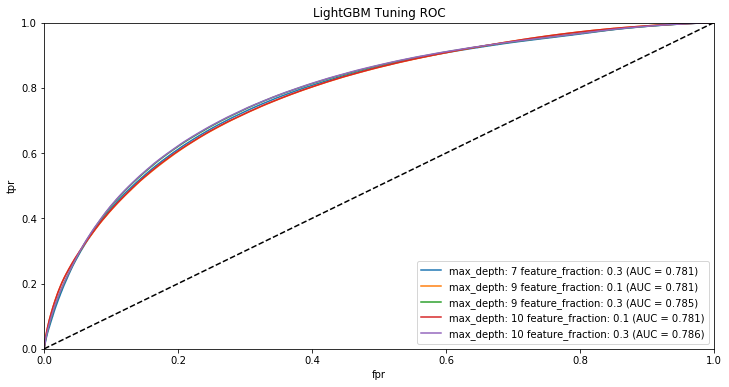

In [85]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)



for fpr, tpr, roc_label, auc in zip(fprs, tprs, roc_labels, roc_auc_score): 
    if auc >=0.78:
        plt.plot(fpr, tpr, label = roc_label + ' (AUC = %0.3f)' % auc)

plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('LightGBM Tuning ROC')
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0,1])
plt.ylim([0, 1])
plt.show()

In [73]:
params = {
        'objective': 'binary',
        'boosting': 'rf',
        'learning_rate': 0.2 ,
        'verbose': 0,
        'num_leaves': 100,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.3,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'max_depth': 10,
        'num_rounds': 20,
        'metric' : ['auc', 'binary_logloss']
    }

lgbm_model = lgb.train(params, train_set = lgb_train, valid_sets = lgb_val, verbose_eval=5)

/Applications/Anaconda/anaconda/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[5]	valid_0's binary_logloss: 0.585084	valid_0's auc: 0.772718
[10]	valid_0's binary_logloss: 0.597275	valid_0's auc: 0.765146
[15]	valid_0's binary_logloss: 0.591575	valid_0's auc: 0.770773
[20]	valid_0's binary_logloss: 0.583073	valid_0's auc: 0.782102
[25]	valid_0's binary_logloss: 0.579917	valid_0's auc: 0.783414
[30]	valid_0's binary_logloss: 0.581778	valid_0's auc: 0.783589
[35]	valid_0's binary_logloss: 0.58038	valid_0's auc: 0.78413
[40]	valid_0's binary_logloss: 0.582512	valid_0's auc: 0.78367
[45]	valid_0's binary_logloss: 0.582822	valid_0's auc: 0.78339
[50]	valid_0's binary_logloss: 0.585346	valid_0's auc: 0.782908


In [82]:
params = {
        'objective': 'binary',
        'boosting': 'gbdt',
        'learning_rate': 0.2 ,
        'verbose': 0,
        'num_leaves': 150,
        'bagging_fraction': 0.5,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.3,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'max_depth': 8,
        'num_rounds': 50,
        'metric' : ['auc', 'binary_logloss']
    }

lgbm_model = lgb.train(params, train_set = lgb_train, valid_sets = lgb_val, verbose_eval=5)

/Applications/Anaconda/anaconda/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[5]	valid_0's binary_logloss: 0.593252	valid_0's auc: 0.777222
[10]	valid_0's binary_logloss: 0.57707	valid_0's auc: 0.775312
[15]	valid_0's binary_logloss: 0.566301	valid_0's auc: 0.779371
[20]	valid_0's binary_logloss: 0.566769	valid_0's auc: 0.783322
[25]	valid_0's binary_logloss: 0.57799	valid_0's auc: 0.782692
[30]	valid_0's binary_logloss: 0.582394	valid_0's auc: 0.784328
[35]	valid_0's binary_logloss: 0.593836	valid_0's auc: 0.78449
[40]	valid_0's binary_logloss: 0.604507	valid_0's auc: 0.784263
[45]	valid_0's binary_logloss: 0.613586	valid_0's auc: 0.784402
[50]	valid_0's binary_logloss: 0.620763	valid_0's auc: 0.783567


In [83]:
params = {
        'objective': 'binary',
        'boosting': 'gbdt',
        'learning_rate': 0.2 ,
        'verbose': 0,
        'num_leaves': 200,
        'bagging_fraction': 0.5,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.3,
        'feature_fraction_seed': 1,
        'max_bin': 300,
        'max_depth': 8,
        'num_rounds': 20,
        'metric' : ['auc', 'binary_logloss']
    }

lgbm_model = lgb.train(params, train_set = lgb_train, valid_sets = lgb_val, verbose_eval=5)

/Applications/Anaconda/anaconda/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[5]	valid_0's binary_logloss: 0.593258	valid_0's auc: 0.777132
[10]	valid_0's binary_logloss: 0.576977	valid_0's auc: 0.775427
[15]	valid_0's binary_logloss: 0.565843	valid_0's auc: 0.779856
[20]	valid_0's binary_logloss: 0.56645	valid_0's auc: 0.783635


In [96]:
# min_length_song = song_data.iloc[song_data['song_length'].idxmin()]
# max_length_song = song_data.iloc[song_data['song_length'].idxmax()]
# print(min_length_song[['artist_name', 'composer', 'lyricist', 'number_of_composers',
#                       'number_of_lyricists', 'song_length', 'repeat_play_chance']], '\n')

song.iloc[5]

song_id        kKJ2JNU5h8rphyW21ovC+RZU+yEHPM+3w85J37p7vEQ=
song_length                                          235520
genre_ids                                   864|857|850|843
artist_name                                            貴族精選
composer                                       Joe Hisaishi
lyricist                                     Hayao Miyazaki
language                                                 17
Name: 5, dtype: object

In [94]:
train.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'user_sum', 'user_count', 'is_new_user',
       'song_sum', 'song_count', 'song_freq', 'is_new_song', 'song_length',
       'genre_ids', 'artist_name', 'composer', 'lyricist', 'language',
       'art_sum', 'art_count', 'art_freq', 'is_new_art', 'is_art_dump',
       'uasum', 'uacount', 'uafreq', 'genre_sum', 'genre_count',
       'is_new_genre', 'is_genre_dump', 'ugsum', 'ugcount', 'city', 'bd',
       'gender', 'registered_via', 'registration_init_time', 'expiration_date',
       'numactivedays', 'day_id_res', 'day_id_exp', 'r_year', 'r_month',
       'r_day', 'e_year', 'e_month', 'e_day', 'is_male', 'is_female',
       'age_mtrue', 'age_clean', 'song_year'],
      dtype='object')